In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

## Продвинутое машинное обучение - Домашнее задание 1
Ссылка на данные : https://ourworldindata.org/coronavirus-source-data 

In [4]:
# Конфигурационные переменные
DATA_PATH = "owid-covid-data.csv"
TARGET = ["total_cases" ,"new_cases"]
TRAIN_SIZE = 50
COUNTRY_NAME  = "Russia"
START_DATE = '2020-03-03'

In [5]:
df = pd.read_csv(DATA_PATH)

Датасет большой, состоит из многих параметров, некоторые из которых имеют пропущенные значения.

In [6]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [167]:
class corona_pipeline:
    def __init__(self, data_path):
        self.df = pd.read_csv(data_path)
        self.param_power = 2
        self.train_size = 50

    def preprocess(self, country_name, start_date):
        self.df = self.df[self.df['location'] == country_name]
        self.df = self.df[self.df['date'] >= start_date]
        self.df.loc[self.df['new_cases'] == 0,'new_cases'] = 1
        self.df.index = self.df['date']

    def split_train_test(self, train_size, target):
        self.train_size = train_size
        self.target = target
        self.test_size = len(self.df) - train_size
        self.train = self.df.head(self.train_size)  
        self.test = self.df.tail(self.test_size)
        self.X_train = np.array([i for i in range(self.train_size)])
        self.y_train = self.train[target]
        self.X_test = np.array([train_size + i for i in range(self.test_size)])
        self.y_test = self.test[target]
    
    def gen_exp(self, powers_list, sz):
        return [np.exp(np.sum([powers_list[j] * np.power(x, j) for j in range(len(powers_list))])) for x in range(sz)]

    def plot_train(self, features_to_show, x_ticks_interval = mdates.DayLocator(interval=10), plot_name =  "Train plot"):
        fig, ax = plt.subplots()
        for feature in features_to_show:
            ax.plot(self.y_train.index, self.y_train[feature], label = feature)
        fig.autofmt_xdate()
        ax.xaxis.set_major_locator(x_ticks_interval)
        ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
        plt.title(plot_name)
        return fig, ax 
    
    def plot_val(self, features_to_show,val_size = 20, x_ticks_interval = mdates.DayLocator(interval=4), plot_name =  "Validation plot"):
        fig, ax = plt.subplots()
        self.y_val = self.y_test.head(val_size)
        self.X_val = self.X_test[:val_size]
        for feature in features_to_show:
            ax.plot(self.y_val.index, self.y_val[feature], label = feature)
        fig.autofmt_xdate()
        ax.xaxis.set_major_locator(x_ticks_interval)
        ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
        plt.title(plot_name)
        return fig, ax 
    
    def sample_statistics(self, xs, mu , sigma, n=20):
        my_w = np.random.multivariate_normal(mu, sigma, n)
        res = np.zeros((n, xs.shape[0]))
        for i, w in enumerate(my_w):
            res[i,:] = np.sum([w[j]  *  np.power(xs, j) for j in range(len(w))])
        print(res)
        return np.mean(res, axis = 1)

    def bayesian_update(self, mu, sigma, x, y, sigma_noise=.25):
        x_matrix = np.array([[x**i for i in range(self.param_power)]])
        sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
        mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
        return mu_n, sigma_n

    def myplot_sample_lines(self, mu, sigma, n=20, points=None):
        my_w = np.random.multivariate_normal(mu, sigma, n)
        for w in my_w:
                y = self.gen_exp(w, self.train_size)
                plt.plot(self.X_train, y,  'k-', lw=.4)
        if not points is None:
            plt.scatter(points[0], points[1], marker='*', s=200)
        plt.show()

    def train_linear_regression(self, train_target, baseline_points, param_power, my_mu0 = None, my_sigma0 = None):
        self.param_power = param_power
        sigma_noise = np.mean([( baseline_points[i] - np.log(self.y_train[train_target][i]))**2 for i in range(TRAIN_SIZE)])
        print(f"noise estimation is {sigma_noise}")
        mu0 = [0] * param_power
        sigma0 = np.eye(param_power)
        if my_mu0 != None:
            mu0 = my_mu0 
        if my_sigma0 != None:
            sigma0 = my_sigma0
        mu = [mu0]
        sigma = [sigma0]
        for sample in range(self.train_size):
            mu_n, sigma_n = self.bayesian_update(mu[-1], sigma[-1], sample, np.log(self.y_train[train_target][sample]), sigma_noise)
            mu.append(mu_n)
            sigma.append(sigma_n)
            if sample  % 10 == 0:
                self.myplot_sample_lines(mu[-1], sigma[-1], 20)
        self.mu = mu[-1]
        self.sigma = sigma[-1]
        print(f"result mu is {self.mu}, result sigma is {self.sigma}")

    def predict(self, data):
        powers_list = np.random.multivariate_normal(self.mu, self.sigma, 1)[0]
        ans = [np.exp(np.sum([powers_list[j] * np.power(x, j) for j in range(len(powers_list))])) for x in data]
        return ans
    
    def sample_predict(self, data, positive_score = 90 , negative_score = 10, n = 100):
        pos_pred = []
        neg_pred = []
        for x in data:
            pred = []
            for iter in range(n):
                res = self.predict([x])
                pred.append(res[0]) 
            pred.sort()
            q  = np.percentile (pred, [negative_score, positive_score])
            neg_pred.append(q[0])
            pos_pred.append(q[1])
        return pos_pred, neg_pred



В рамках corona_pipeline реализованы методы рассчета и визуализации регрессии

In [155]:
my_pipeline = corona_pipeline(DATA_PATH)
my_pipeline.preprocess(COUNTRY_NAME, START_DATE)
my_pipeline.split_train_test(TRAIN_SIZE, TARGET)

Наша целевая переменная состоит из двух столбцов: "total cases"(общее число заболевших) и "new cases"(количество новых заболевших за день). Наша обучаемая выборка состоит из значений за первые 50 дней пандемии в России, X - номер дня начиная с 3 марта 2020 года. Займемся предсказанием общего числа заболевших. Если мы не будем заглядывать " в будущее " и забудем о природе целевой переменной, то распределение похоже на экспоненциальное.

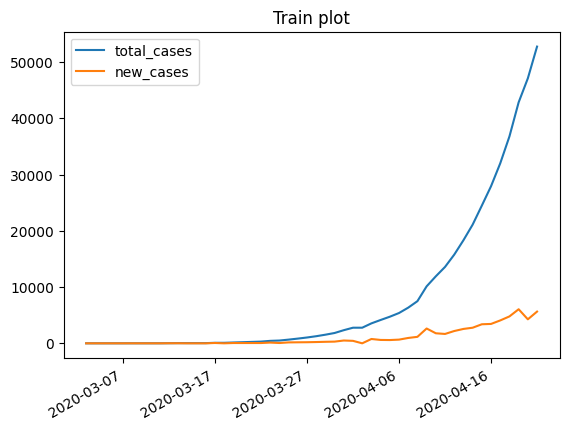

In [156]:
fig, ax = my_pipeline.plot_train(TARGET)
ax.legend()
plt.show()

Найдем бейзлайн вида $e^{Ax+b}$. Эмпирически подберем коэффициенты, график которых визуально накладывается  на реальные данные за первые 50 дней. Также на основе этого распределения будет оцениваться шум распределения как MSE между бейзлайлом и тренировочными данными.

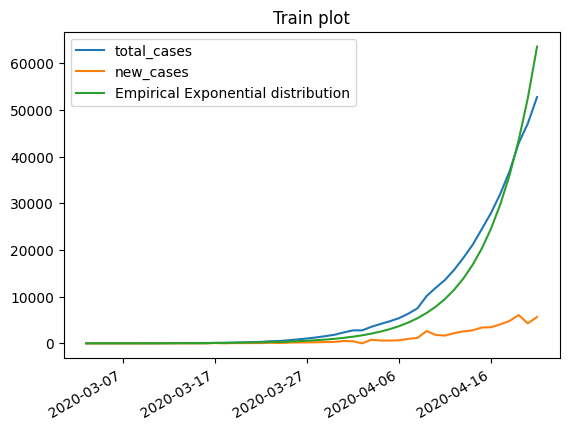

In [157]:
fig, ax = my_pipeline.plot_train(TARGET)
powers_list = [ 1.75, 0.19 ]
baseline_points = my_pipeline.gen_exp(powers_list , TRAIN_SIZE)
ax.plot(my_pipeline.y_train.index, baseline_points, label = f"Empirical Exponential distribution")
baseline_points = np.log(baseline_points)
ax.legend()
plt.show()

Мы воспрользуемся преобразованием значений целевой переменной $y = e^{Ax+b}$, прологарифмируем ее, получим $log(y) = Ax+b$, будем искать параметры A и b с помощью линейной регрессии. На графиках ниже представлены пучки кривых y, построенные на основе линейной регресси обученной на разном количестве точек. Как мы можем видеть, в принципе метод относительно сошелся

noise estimation is 0.32457624651609185


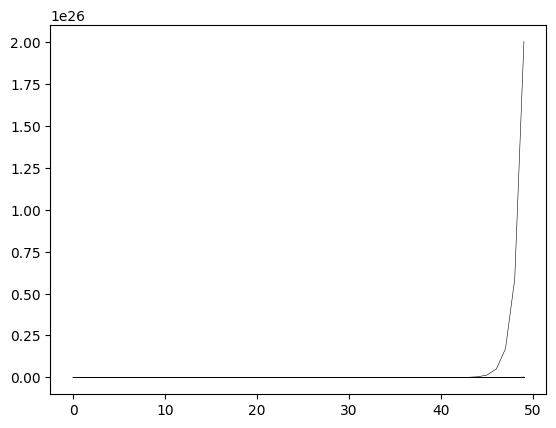

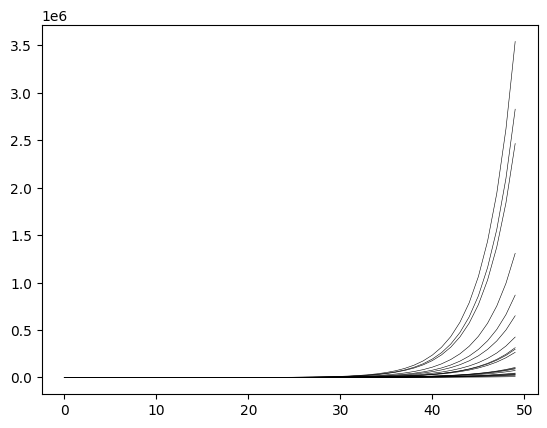

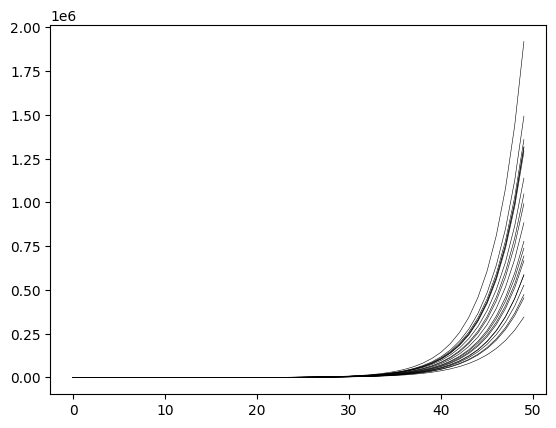

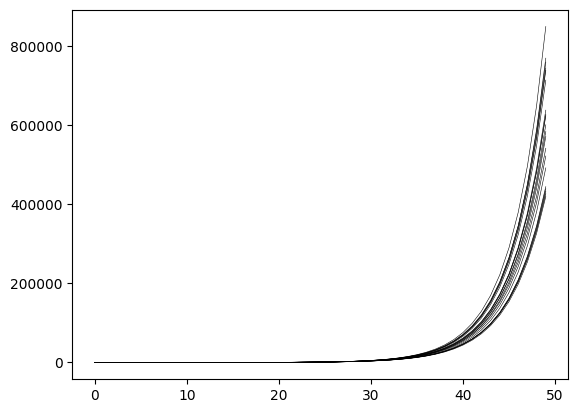

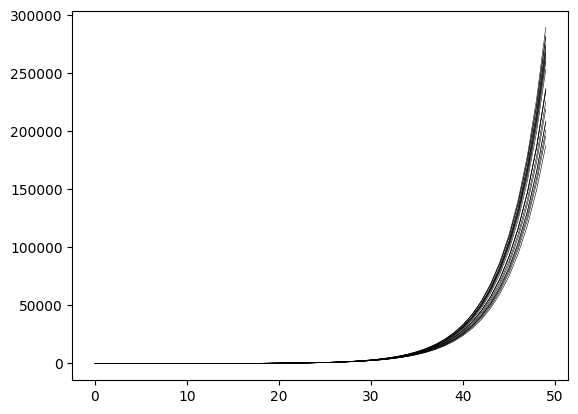

result mu is [1.18378891 0.21439764], result sigma is [[ 8.11366592e-03 -2.45868023e-04]
 [-2.45868023e-04  1.00565741e-05]]


In [158]:
my_pipeline.train_linear_regression('total_cases', baseline_points, 2)

Проиллюстрируем результаты регресси на тренировочных данных. Мы можем видеть, что экспонента, полученная в результате линейной регрессии растет даже быстрее тестовых данных, результат на 50-й день в два раза больше, чем должен быть, это определенно даст негативный результат на стадии валидации

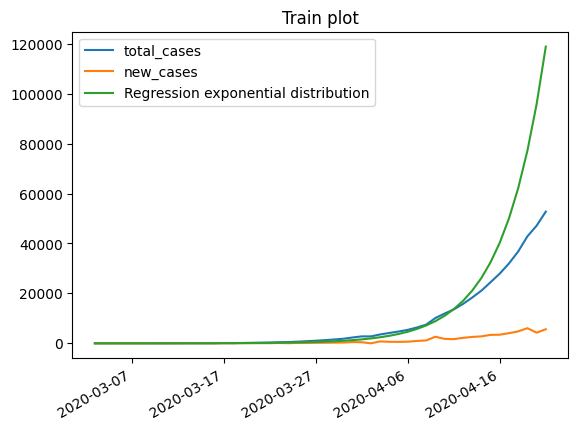

In [159]:
fig, ax = my_pipeline.plot_train(TARGET)
ax.plot(my_pipeline.y_train.index, my_pipeline.predict(my_pipeline.X_train), label = f"Regression exponential distribution")
ax.legend()
plt.show()

Произведем валидацию данных, для валидации возьмем данные за следующие 20 дней. Как и ожидалась, рост экспоненты не является хорошей аппроксимацией для количества зараженных(по крайней мере для ковида),
P.S. Предикт предсказывался по среднему значению, не семплировался (матрица отклонений почти нулевая)

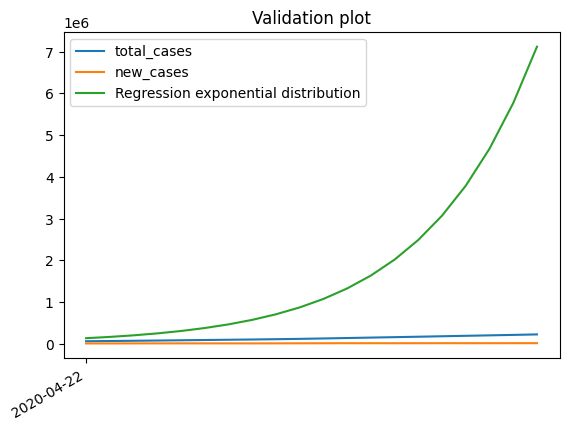

In [161]:
fig, ax = my_pipeline.plot_val(TARGET, 20)
ax.plot(my_pipeline.y_val.index, my_pipeline.predict(my_pipeline.X_val), label = f"Regression exponential distribution")
ax.legend()
plt.show()

Попробуем использовать модель исключающую бесконечный рост, например, гауссиану. Так как гауссовское распредление сложно каким-либо способом переводить в линейную регрессию(с интегралом сложно работать). Будем работать с производной от этого интеграла, по теореме о производной интеграла с переменным верхним пределом,производная от гауссианы это значение ее под знаком интеграла. В свою очередь целевой переменной будет столбец новый случаев заражения( "new cases") как дискретизированный аналог производной столбца "total cases". Общий вид функции, параметры которой мы будем искать имеет вид: $e^{Ax^2+Bx+c}$. Бейзлайн мы ищем вида $\frac{\alpha}{\sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \frac{(x - \mu)^2}{\sigma^2}} $ - его параметры имеют прямую геометрическую зависимость, а значит, с их помощью проще найти похожую кривую. Приведем график бейзлайна, как можно видеть оба распределения достаточно хорошо покрываются

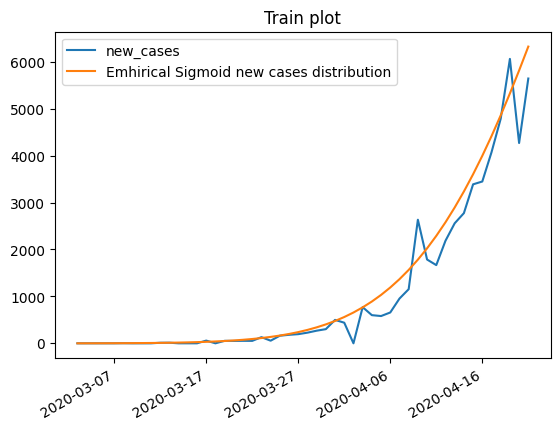

In [162]:
def gen_sigmoid(alpha , mu, sigma,sz):
        return [alpha / (sigma * np.sqrt(2* np.pi)) *  np.exp(-1 / 2 * (x - mu)**2 /sigma**2 ) for x in range(sz)]

def calc_pref_sums(data):
      pref_sums =  data
      for i in range(1,TRAIN_SIZE):
            pref_sums[i] = pref_sums[i] + pref_sums[i-1]
      return pref_sums 

alpha = 600000
mu = 70
sigma = 16
fig, ax = my_pipeline.plot_train(['new_cases'])
baseline_points =  gen_sigmoid(alpha , mu, sigma,  TRAIN_SIZE)
ax.plot(my_pipeline.y_train.index, baseline_points, label = f"Emhirical Sigmoid new cases distribution")
baseline_points = np.log(baseline_points)
pref_sums =  calc_pref_sums( gen_sigmoid(alpha , mu, sigma,  TRAIN_SIZE))
#ax.plot(my_pipeline.y_train.index, pref_sums, label = f"Emhirical Sigmoid total cases distribution")
ax.legend()
plt.show()

Найдем параметры сигмоиды с помощью линейной регрессии по столбцу логарифму новых случаев заражения. Так как получившиеся ковариация далековата от нуля, предсказывыть по среднему нерелевантно

noise estimation is 2.00282013671838


C:\Users\user\AppData\Local\Temp\ipykernel_4692\3624990596.py:25: RuntimeWarning: overflow encountered in exp
  return [np.exp(np.sum([powers_list[j] * np.power(x, j) for j in range(len(powers_list))])) for x in range(sz)]


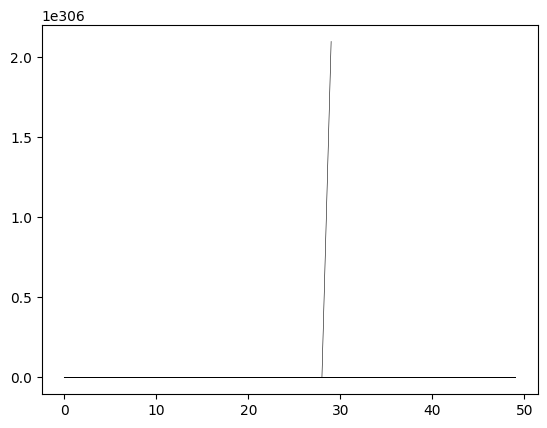

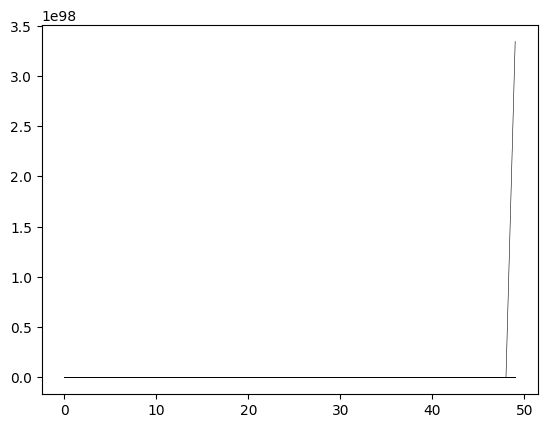

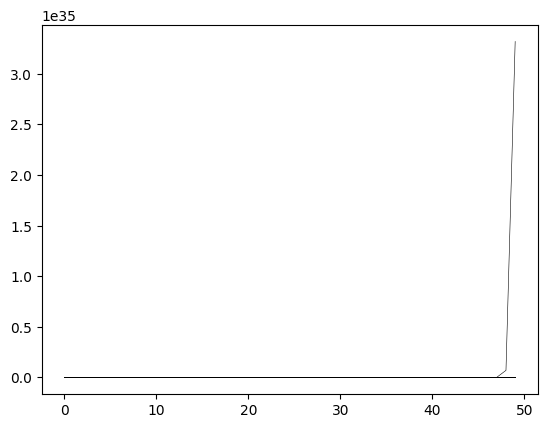

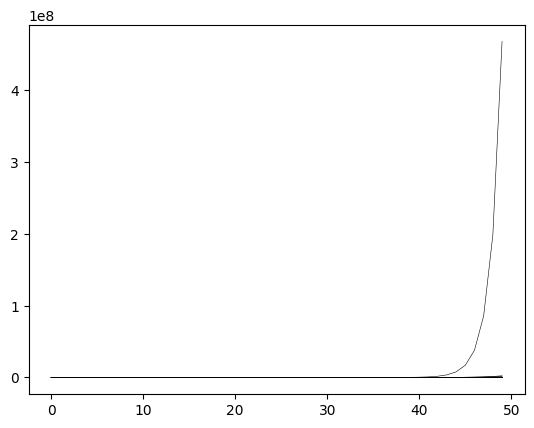

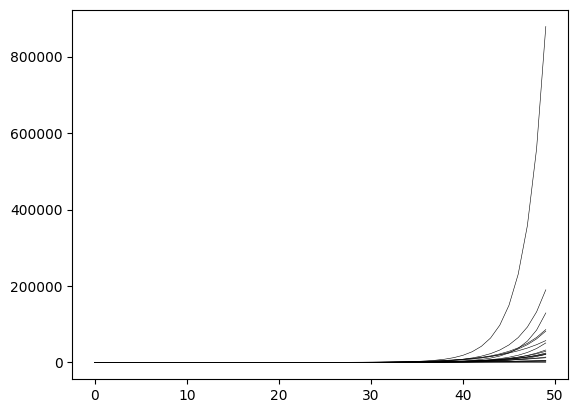

result mu is [-0.51595364  0.22910534 -0.00069602], result sigma is [[ 3.99156677e-01 -3.21984334e-02  5.41630253e-04]
 [-3.21984334e-02  4.18326039e-03 -8.37455807e-05]
 [ 5.41630253e-04 -8.37455807e-05  1.81408011e-06]]


In [163]:
my_pipeline.train_linear_regression('new_cases', baseline_points, 3, [0, 0, 0])

Продемонстрируем результаты на обучающей выборке, просемплируем 100 результатов линейной регресии, возьмем  из них 10 %  и 90 %персентиль как положительную и отрицательную оценку количества новых случаев заражения

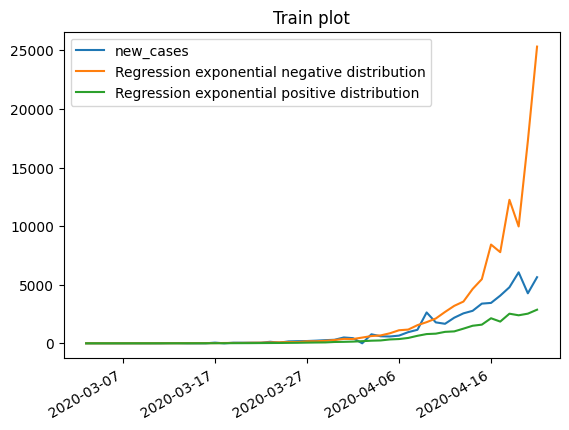

In [164]:
fig, ax = my_pipeline.plot_train(['new_cases'])
res_neg, res_pos =  my_pipeline.sample_predict(my_pipeline.X_train)
ax.plot(my_pipeline.y_train.index, res_neg, label = f"Regression exponential negative distribution")
ax.plot(my_pipeline.y_train.index, res_pos, label = f"Regression exponential positive distribution")
ax.legend()
plt.show()

Несмотря на то, что негативная оценка визуально имеет большее отклоенние от реальной кривой, чем позитивная, ее значение не уходят сильно вверх как было с экспонентной, оценки выглядят вполне адекватно

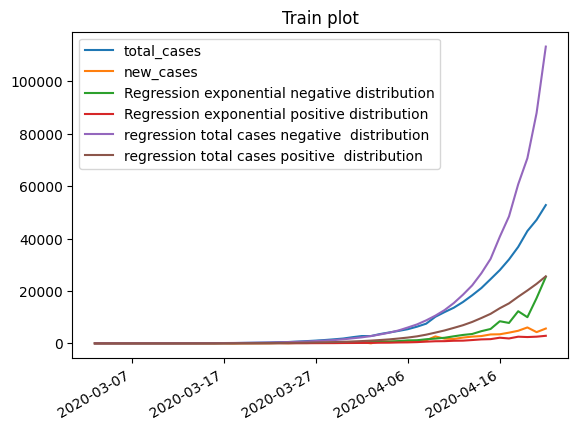

In [165]:
fig, ax = my_pipeline.plot_train(TARGET)
ax.plot(my_pipeline.y_train.index, res_neg, label = f"Regression exponential negative distribution")
ax.plot(my_pipeline.y_train.index, res_pos, label = f"Regression exponential positive distribution")
pref_sums_pos = calc_pref_sums(res_pos)
pref_sums_neg = calc_pref_sums(res_neg)
ax.plot(my_pipeline.y_train.index, pref_sums_neg, label = f"regression total cases negative  distribution")
ax.plot(my_pipeline.y_train.index, pref_sums_pos, label = f"regression total cases positive  distribution")
ax.legend()
plt.show()

Посмотрим какие результаты будут на валидационной выборке. Негативная оценка также как и экспонента ушла наверх, то есть в негативной перспективе ожидается околоэкспоненциальный рост,позитивная же скачет, но показывает в среднем в полтора меньше, чем реальные данные 

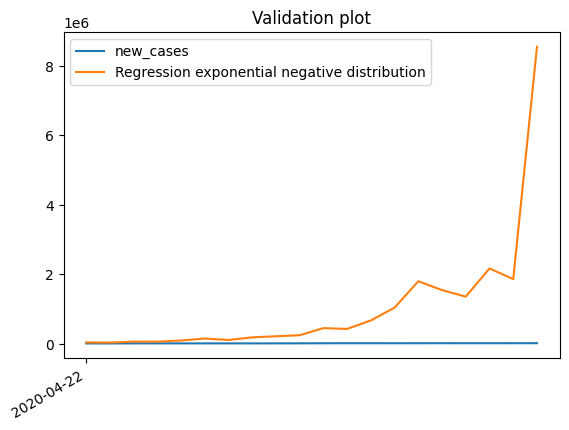

In [169]:
fig, ax = my_pipeline.plot_val(['new_cases'])
res_neg, res_pos =  my_pipeline.sample_predict(my_pipeline.X_val)
ax.plot(my_pipeline.y_val.index, res_neg, label = f"Regression exponential negative distribution")
#ax.plot(my_pipeline.y_val.index, res_pos, label = f"Regression exponential positive distribution")
ax.legend()
plt.show()

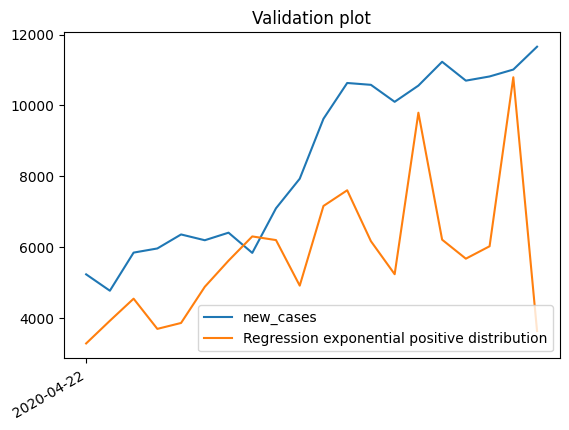

In [168]:
fig, ax = my_pipeline.plot_val(['new_cases'])
res_neg, res_pos =  my_pipeline.sample_predict(my_pipeline.X_val)
#ax.plot(my_pipeline.y_val.index, res_neg, label = f"Regression exponential negative distribution")
ax.plot(my_pipeline.y_val.index, res_pos, label = f"Regression exponential positive distribution")
ax.legend()
plt.show()

Думаю, результаты второй модели были бы лучше, если бы тренировочная выборка была больше. Но эта модель также неспособна отразить кривую заболеваемости полностью, так как плотность гауссианы может описать всего один пик, а временные ряды заболеваемости имеют волновую струтуру, то есть множество пиков. В принципе, можно попробовать взять смесь распределений для каждого года, например три распределения: каждый день зависитт от трех гауссиан -  гауссиана откликов заболевших в предыдущую волну, гауссиана текущей волны, гауссиана заболевших новой волны (их можно разделить, например, по смене сезона или штамма вируса?): Тогда $f(x) =  e^{A_1x^2+B_1+C_1} +  e^{A_1x^2 + B_2x + C_2 } +  e^{A_3x^2 + B_3x+C_3}$. Для начального года их можно найти EM алгоритмом

Text(0.5, 1.0, 'All values')

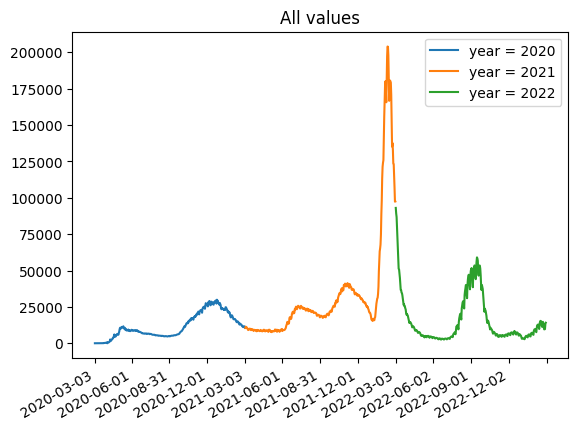

In [177]:
fig, ax = plt.subplots()
x_ticks_interval = mdates.MonthLocator(interval=3)
interval = 365
for i in range(3):
    ax.plot(my_pipeline.df['date'][ i * 365: ((i+1) * 365)], my_pipeline.df['new_cases'][ i * 365: ((i+1) * 365)], label  = f"year = {2020+i}")
fig.autofmt_xdate()
ax.legend()
ax.xaxis.set_major_locator(x_ticks_interval)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title("All values")

Text(0.5, 1.0, 'All values')

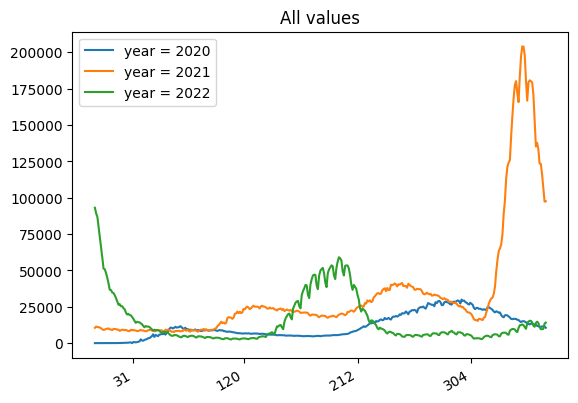

In [182]:
fig, ax = plt.subplots()
x_ticks_interval = mdates.MonthLocator(interval=3)
interval = 365
for i in range(0,3):
    ax.plot([i for i in range(interval)], my_pipeline.df['new_cases'][ i * 365: ((i+1) * 365)], label  = f"year = {2020+i}")
fig.autofmt_xdate()
ax.legend()
ax.xaxis.set_major_locator(x_ticks_interval)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title("All values")